# EDA (downloaded document corpus) for 'debiaser' data product
#### Sagar Setru, September 21th, 2020

## Brief description using CoNVO framework

### Context

Some people are eager to get news from outside of their echo chamber. However, they do not know where to go outside of their echo chambers, and may also have some activation energy when it comes to seeking information from other sources. In the meantime, most newsfeeds only push you content that you agree with. You end up in an echo chamber, but may not have ever wanted to be in one in the first place.

### Need

A way to find news articles from different yet reliable media sources.

### Vision

Debiaser, a data product (maybe Chrome plug-in?) that will recommend news articles similar in topic to the one currently being read, but from several pre-curated and reliable news media organizations across the political spectrum, for example, following the "media bias chart" here https://www.adfontesmedia.com/ or the "media bias ratings" here: https://www.allsides.com/media-bias/media-bias-ratings. The app will determine the main topics of the text of a news article, and then show links to similar articles from other news organizations.

The product will generate topics for a given document via latent Dirichlet allocation (LDA) and then search news websites for the topic words generated.

Caveats: Many of these articles may be behind paywalls. News aggregators already basically do this. How different is this than just searching Google using the title of an article?

### Outcome

People who are motivated to engage in content outside of their echo chambers have a tool that enables them to quickly find news similar to what they are currently reading, but from a variety of news organizations.

### testing single document lda on these articles

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

import json

from google.cloud import storage
from flask import escape

# NLP Packages
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.utils import simple_preprocess

# to break articles up into sentences
from nltk import tokenize

import pyLDAvis
import pyLDAvis.gensim

from text_processing_functions import process_all_articles
from text_processing_functions import remove_stopwords
from text_processing_functions import get_simple_corpus_dictionary_bow
from text_processing_functions import entity_recognizer
from text_processing_functions import get_topic_words_mean_std_prob_frequency
from text_processing_functions import sort_topics_mean_frequency

In [12]:
all_news_df = pd.read_csv('./all_the_news/all_news_df_processed.csv')
all_news_df.head()

/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,index,index.1,id,title,author,date,content,year,month,publication,category,digital,section,url,article_length
0,0,0,1,Agent Cooper in Twin Peaks is the audience: on...,\nTasha Robinson\n,2017-05-31,And never more so than in Showtime’s new...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN,2121
1,1,1,2,"AI, the humanity!",\nSam Byford\n,2017-05-30,AlphaGo’s victory isn’t a defeat for hum...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN,1948
2,2,2,3,The Viral Machine,\nKaitlyn Tiffany\n,2017-05-25,Super Deluxe built a weird internet empi...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN,3011
3,3,3,4,How Anker is beating Apple and Samsung at thei...,\nNick Statt\n,2017-05-22,Steven Yang quit his job at Google in th...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN,3281
4,4,4,5,Tour Black Panther’s reimagined homeland with ...,\nKwame Opam\n,2017-05-15,Ahead of Black Panther’s 2018 theatrical...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN,239


In [6]:
# del process_all_articles
# process_all_articles

In [7]:
def load_stop_words_csv_to_list(full_file_name):
    """fxn that loads stop words list downloaded from git repo called 'news-stopwords'"""
    
    stop_words = pd.read_csv(full_file_name)

    stop_words = stop_words['term']

    stop_words = [word for word in stop_words]
    
    return stop_words

In [8]:
def lemmatize(raw_texts,nlp):

    'Function that lemmatizes text'

    out_text = []
    
    for text in raw_texts:
        doc = nlp(text)


        #Remove stopwords and lemmatize
        tokens = [token.lemma_ for token in doc]
        
        out_text.append(tokens)
    
    return out_text

In [9]:
def get_simple_corpus_dictionary_bow(texts,word_frequency_threshold):
    """fxn returns corpus, proc. dict, bag of words"""
    
    # Count word frequencies
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1

    # Only keep words that appear more than set frequency, to produce the corpus
    processed_corpus = [[token for token in text if frequency[token] > word_frequency_threshold] for text in texts]
    
    # generate a dictionary via gensim
    processed_dictionary = Dictionary(processed_corpus)
    
    # generate bag of words of the corpus
    bow_corpus = [processed_dictionary.doc2bow(text) for text in processed_corpus]
    
    return processed_corpus, processed_dictionary, bow_corpus

In [10]:
def sort_topics_mean_frequency(topics,topics_mean_probs_dict,topics_std_probs_dict,topics_frequency_dict):
    """fxn returns topics sorted by their mean probability and frequency. also returns std dev of prob"""
    
    # empty dict for topics
    x_topics = []
    
    # to store mean probs
    y_means = np.zeros((len(topics_mean_probs_dict)))
    
    # to store std dev probs
    y_std = np.zeros((len(topics_std_probs_dict)))
    
    # to store frequency of topic
    y_frequencies = np.zeros((len(topics_frequency_dict)))

    # measure mean probs
    counter = -1
    for topics, mean_prob in topics_mean_probs_dict.items():
        counter += 1
        x_topics.append(topics)
        y_means[counter] = mean_prob

    # measure std dev probs
    counter2 = -1
    for topics, frequency in topics_frequency_dict.items():
        counter2 += 1
        y_frequencies[counter2] = frequency

    # measure frequency topic shows up
    counter3 = -1
    for topics, std in topics_std_probs_dict.items():
        counter3 += 1
        y_std[counter3] = std

    # sort by mean and frequency

    zipped_mean = zip(y_means, x_topics)
    sorted_zipped_mean = sorted(zipped_mean)
    y_means_sorted = [element1 for element1,element2 in sorted_zipped_mean]
    y_means_sorted = y_means_sorted[::-1]
    x_topics_means = [element2 for element1,element2 in sorted_zipped_mean]
    x_topics_means = x_topics_means[::-1]

    zipped_mean_std = zip(y_means,y_std)
    sorted_zipped_mean_std = sorted(zipped_mean_std)
    y_std_sorted = [element2 for element1,element2 in sorted_zipped_mean_std]
    y_std_sorted = y_std_sorted[::-1]

    zipped_freq = zip(y_frequencies,x_topics)
    sorted_zipped_freq = sorted(zipped_freq)
    y_freq_sorted = [element1 for (element1,element2) in sorted_zipped_freq]
    y_freq_sorted = y_freq_sorted[::-1]
    x_topics_freq = [element2 for element1,element2 in sorted_zipped_freq]
    x_topics_freq = x_topics_freq[::-1]
    
    return x_topics_means, y_means_sorted, y_std_sorted, x_topics_freq, y_freq_sorted

In [13]:
# choose list of stop words

# choose whether 1k, 10k, 100k, or nltk
which_stop_words = '1k'
# which_stop_words = '10k'
# which_stop_words = '100k'
# which_stop_words = 'nltk'

stop_words_path = '/Users/sagarsetru/Documents/post PhD positions search/insightDataScience/project/debiaser/stop_words_db/news-stopwords-master/'


if which_stop_words == '1k':
    
    # doing 1k words list
    stop_words_file_name = 'sw1k.csv'
    
    # make full file name
    stop_words_full_file_name = stop_words_path+stop_words_file_name
    
    # get list of stop words
    stop_words = load_stop_words_csv_to_list(stop_words_full_file_name)
    
elif which_stop_words == '10k':
    
    # doing 10k words list
    stop_words_file_name = 'sw10k.csv'

    # make full file name
    stop_words_full_file_name = stop_words_path+stop_words_file_name
    
    # get list of stop words
    stop_words = load_stop_words_csv_to_list(stop_words_full_file_name)

elif which_stop_words == '100k':
    
    # doing 100k
    stop_words_file_name = 'sw100k.csv'  
    
    # get full file name
    stop_words_full_file_name = stop_words_path+stop_words_file_name
    
    # get list of stop words
    stop_words = load_stop_words_csv_to_list(stop_words_full_file_name)


elif which_stop_words == 'nltk':
    # import from nltk
    from nltk.corpus import stopwords
    
    stop_words = stopwords.words('english')
    
else:
    print('Select proper variable name for "which_stop_words"')
    
# adding custom words
stop_words.append('said')
stop_words.append('youre')

In [14]:
# get a random sampling of these articles for testing single document lda

n_sample = 10

articles_df_random_subset = all_news_df.sample(n=n_sample)

In [16]:
def entity_recognizer(raw_text,nlp):
    """Function that recognizes specific entitites, returns dictionary of them"""

    doc = nlp(raw_text)
    
    entity_dict = {}
    
    word_types = ['DATE', 'PERSON', 'ORG','MONEY','GPE']
    
    for word_type in word_types:
        entity_dict[word_type] = [entity.text for entity in doc.ents if entity.label_ in {word_type}]
    
    return entity_dict

In [83]:
full_path = '/Users/sagarsetru/Documents/post PhD positions search/insightDataScience/project/debiaser/article_text_files/'

full_file_names = [
full_path+'ap_hurricane_sally_unleashes_20200916.txt',
full_path+'cnn_big_ten_backtracks_20200916.txt',
full_path+'nyt_on_the_fire_line_20200915.txt',
full_path+'foxnews_snake_face_mask_20200916_v2.txt',
'/Users/sagarsetru/Documents/post PhD positions search/insightDataScience/project/debiaser/article_html_files/U.S. Stocks Lower as Fed Outlook Rattles Investors - WSJ.html'
]

from bs4 import BeautifulSoup

import requests

# full_file_name = full_file_names[4]

# # with open(full_file_name, 'r') as file:
# #     main_article = file.read().replace('\n', ' ')
    
    
# # get the html as one string
# with open(full_file_name, 'r') as file:
#     coverpage = file.read()

url = 'https://www.nytimes.com/2020/09/27/us/politics/trump-biden-debate-expectations.html?action=click&module=Top%20Stories&pgtype=Homepage'
# url = 'https://www.nytimes.com/2020/09/25/us/politics/rbg-retirement-obama.html'
page = requests.get(url)
coverpage = page.content

In [84]:
# create soup object
soup = BeautifulSoup(coverpage, 'html.parser')

# get title
headline = soup.find('h1').get_text()
print(headline)
print(' ')

# get text from all <p> tags
p_tags = soup.find_all('p')

# get text from each p tag and strip whitespace
p_tags_text = [tag.get_text().strip() for tag in p_tags]

# filter out sentences without periods
p_tags_text = [sentence for sentence in p_tags_text if '.' in sentence]

# convert all p_tags_text to single article text string

p_tags_text_1string = ''

for p_tag_text in p_tags_text:
    p_tags_text_1string += p_tag_text

main_article = p_tags_text_1string

By Lowering the Debate Bar for Biden, Has Trump Set a Trap for Himself?
 


In [85]:
entity_recognizer(headline,nlp)


{'DATE': [], 'PERSON': [], 'ORG': [], 'MONEY': [], 'GPE': []}

In [86]:
main_article

'President Trump has worked overtime to persuade followers that Joe Biden is addled and incoherent. That could backfire if Mr. Biden doesn’t fit the caricature.WASHINGTON — President Trump has framed the first general election debate as a test for his opponent, former Vice President Joseph R. Biden Jr.Yet he has simultaneously set the bar so low for so long that many of his supporters — having watched unflattering, often manipulated clips of Mr. Biden in Trump campaign advertisements or on Fox News — are now expecting the president to mop the floor with an incoherent opponent in something resembling a W.W.E. match.Democrats — and even some Republicans — believe that is not likely to happen.The misleading notion that Mr. Biden is too addled for the presidency has been driven by Mr. Trump since 2018, when he first started referring to the former vice president as Sleepy Joe. Since then, in speeches, in interviews and at his rallies, Mr. Trump has been crafting a narrative depicting the f

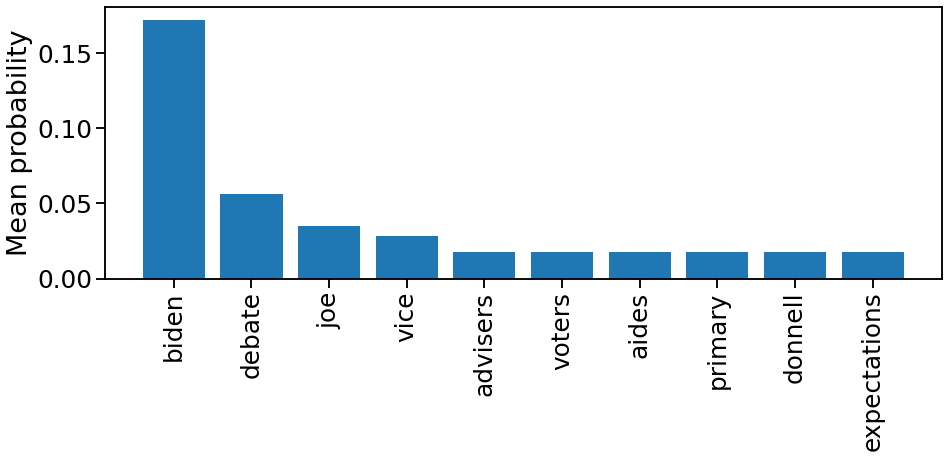

<Figure size 432x288 with 0 Axes>

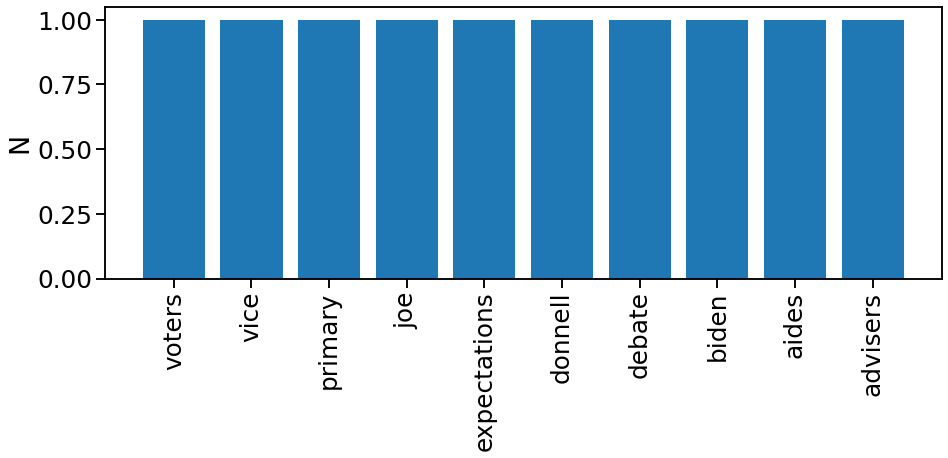

<Figure size 432x288 with 0 Axes>

In [93]:
# Create a floor of the frequency of words to remove
word_frequency_threshold = 1

# choose the number of LDA topics
num_lda_topics = 1

# do by sentences
do_sentences = 1

do_plot = 1

do_print = 0

n_passes = 1

n_runs = 1

unique_topic_words = 1

perplexity_scores = np.zeros((n_runs,1))

counter = -1
for i in range(n_runs):
    counter += 1
    # loop through articles
    # for ind, full_file_name in enumerate(full_file_names):

    # for ind, article_text in enumerate(articles_df_random_subset['content']):
#     for ind, article_text in enumerate([articles_df_random_subset.iloc[1,6]]):
    for ind, article_text in enumerate([main_article]):




    #     if ind == 0:
    #         continue

        if do_print:
            print(article_text)

        # pull out dictionary of important entities
    #     entity_dict = entity_recognizer(article_text,nlp)

    #     if do_print:
    #         print(' ')

    #     for key in entity_dict:

    #         if do_print:
    #             print(key)
    #             print(entity_dict[key])
    #             print(' ')

    #     # replace weird apostrophes
    #     article_text = article_text.replace("`","'")
    #     article_text = article_text.replace("’","'")
    #     article_text = article_text.replace("'","'")

    #     # replace long dashes with short dashes
    #     article_text = article_text.replace("—","-")

    #     # replace short dashes with spaces
    #     article_text = article_text.replace("-"," ")

        if do_sentences:
            # break article into sentences
            article_text = tokenize.sent_tokenize(article_text)

    #         article_text = [sentence.translate(sentence.maketrans('', '', string.punctuation)) for sentence in article_text]

            # process article
            article_processed = process_all_articles(article_text,nlp)

            # remove stopwords
            article_processed = remove_stopwords(article_processed,stop_words)

            # following https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html#sphx-glr-auto-examples-core-run-core-concepts-py
            # Lowercase each document, split it by white space and filter out stopwords
    #         texts = [[word for word in document.lower().split() if word not in stop_words] 
    #                  for document in article_text]

        else:
            # get rid of punctuation
            article_text = article_text.translate(article_text.maketrans('', '', string.punctuation))

            # following https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html#sphx-glr-auto-examples-core-run-core-concepts-py
            # Lowercase each document, split it by white space and filter out stopwords
            article_processed = [[word for word in document.lower().split() if word not in stop_words] for document in [article_text]]

        # get corpus, dictionary, bag of words
        processed_corpus, processed_dictionary, bow_corpus = get_simple_corpus_dictionary_bow(article_processed,
                                                                                              word_frequency_threshold)

        # generate the LDA model
        lda = LdaModel(corpus = bow_corpus,
                         num_topics = num_lda_topics,
                         id2word = processed_dictionary,
                         passes = n_passes)

        # get the topics from the lda model
        lda_topics = lda.show_topics(formatted=False)

        # dictionary for topics and the probabilities associated with them
        topics_probs_dict = {}

        # list of unique topic names
        topics = []

        # loop through each list of generated topics
        for topic in lda_topics:

            # get the list of topics
            topic_words = topic[1]

            # loop through topic words and probabilities
            for topic_word, prob in topic_words:

                # if the word isn't already in the list of topics, add it to list of topics
                if topic_word not in topics: 
                    topics.append(topic_word)

                # if the word is not a key in the dictionary of topics to probabilities, add it to dictionary
                if topic_word not in topics_probs_dict.keys():

                    topics_probs_dict[topic_word] = np.array([prob])

                # if the word is a key in the dictionary of topics to probabilities, append probability
                else:
                    topics_probs_dict[topic_word] = np.append(topics_probs_dict[topic_word],[prob])

        # dictionary for topic probability means
        topics_mean_probs_dict = {}

        # dictionary for topic probability std devs
        topics_std_probs_dict = {}

        # dictionary for topic frequency
        topics_frequency_dict = {}

        # loop through topics and probabilities
        for topic, prob in topics_probs_dict.items():

            # update dictionary for mean probability
            topics_mean_probs_dict[topic] = np.mean(prob)

            # update dictionary for std dev probability
            topics_std_probs_dict[topic] = np.std(prob)

            # update dictionary for topic frequency
            topics_frequency_dict[topic] =  prob.size



        # get the topic mean probs and frequencies, sorted
        topics_means, means_sorted, std_sorted, topics_freq, freq_sorted = sort_topics_mean_frequency(topics,
                                                 topics_mean_probs_dict,
                                                 topics_std_probs_dict,
                                                 topics_frequency_dict)

        
        
        # get top words per topic
        lda_top_topic_words = ''        

        # list is for checking previous words
        lda_top_topic_words_list = []

        if not unique_topic_words:

            for topic in lda_topics:

                # get the list of topics
                topic_words = topic[1]

                lda_top_topic_words += ' '+topic_words[0][0]

        else:

            # loop through each list of generated topics
            for topic in lda_topics:

                # set word added to 0
                word_added = 0

                # get the list of topics
                topic_words = topic[1]

                # loop through words in topic
                # add as search term only if they aren't already search terms
                for i in range(len(topic_words)):

                    # if the current word in topic is not in list of search terms
                    if topic_words[i][0] not in lda_top_topic_words_list:

                        # add this word to list of topic/search terms
                        lda_top_topic_words_list.append(topic_words[i][0])

                        # also update the string for the search terms
                        lda_top_topic_words += ' '+topic_words[i][0]

                        # update word added
                        word_added = 1
                        break

                # if no word was added because all supporting words in topic are already
                # search terms, then just add the highest prob/first word in topic
                if word_added == 0:
                    # if every word in this topic is already a search term,
                    # just add the first most probable word and leave the while loop
                    lda_top_topic_words_list.append(topic_words[0][0])
                    lda_top_topic_words += ' '+topic_words[0][0]
        
        if do_plot:
            plt.figure(figsize=(15,5));
            plt.bar(topics_means,means_sorted,yerr=std_sorted);
            plt.ylabel('Mean probability');
            sns.set_context('talk', font_scale=1.5);
            plt.xticks(rotation=90);
            plt.show();
            plt.clf();
        #     plt.savefig('./eda_figs/mean_prob_vs_topic_big_ten_resumes.png', dpi=300, bbox_inches='tight')

            plt.figure(figsize=(15,5));
            plt.bar(topics_freq,freq_sorted);
            plt.ylabel('N');
            # plt.xlabel('Topics')
            sns.set_context('talk', font_scale=1.5);
            plt.xticks(rotation=90);
            plt.show();
            plt.clf();
            # plt.savefig('./edafigs/frequency_vs_topic_big_ten_resumes.pdf')

        if do_print:
            print(topics)
            print(topics_probs_dict)
            print(' ')

            for lda_topic in lda_topics:
                print(lda_topic)

            print(lda_top_topic_words)

    #     print(' ')
    #     if ind == 0:
    #         break
    perplexity = lda.log_perplexity(bow_corpus)
    perplexity_scores[counter] = perplexity
        
        
# print('\nPerplexity: ', lda.log_perplexity(bow_corpus))

# Visualize the topics

if num_lda_topics > 1:
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda, bow_corpus, processed_dictionary)
    vis


In [91]:
lda_top_topic_words = ''

n_topic_words = 3

for topic in lda_topics:
                
    # get the list of topic words
    topic_words = topic[1]

    # loop through these words and get the top n number
    counter = -1
    for topic_word in topic_words:

        counter += 1

        if counter < n_topic_words:

            lda_top_topic_words += ' '+topic_word[0]

In [92]:
lda_top_topic_words

' biden debate joe'

In [94]:
print(np.mean(perplexity_scores))
print(np.std(perplexity_scores))

-3.9157054963694438
0.0


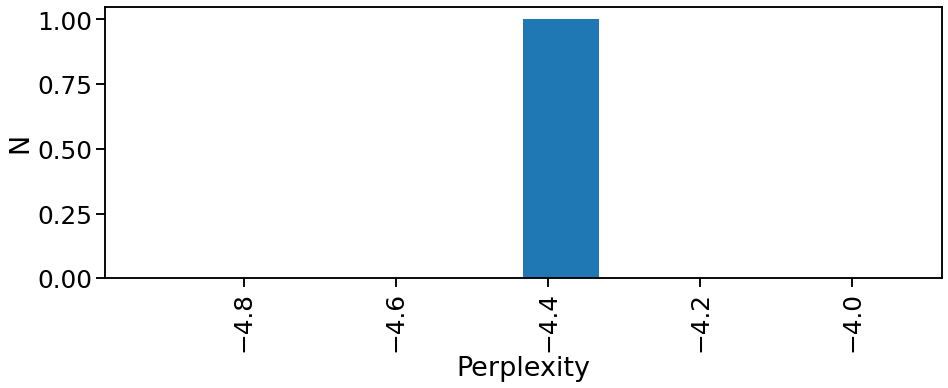

<Figure size 432x288 with 0 Axes>

In [45]:
plt.figure(figsize=(15,5));
plt.hist(perplexity_scores);
plt.ylabel('N');
plt.xlabel('Perplexity')
sns.set_context('talk', font_scale=1.5);
plt.xticks(rotation=90);
plt.show();
plt.clf();

In [37]:
print(len(article_text))
processed_corpus, processed_dictionary, bow_corpus = get_simple_corpus_dictionary_bow(article_processed,
                                                                                          word_frequency_threshold)

17


In [94]:
# lda_top_topic_words
all_sides_domains

0         abcnews.go.com
1          aljazeera.com
2             apnews.com
3                bbc.com
4          bloomberg.com
5          breitbart.com
6       buzzfeednews.com
7                cbn.com
8            cbsnews.com
9          csmonitor.com
10               cnn.com
11     thedailybeast.com
12      democracynow.org
13         factcheck.org
14            forbes.com
15           foxnews.com
16          huffpost.com
17       motherjones.com
18             msnbc.com
19    nationalreview.com
20           nbcnews.com
21            nypost.com
22           nytimes.com
23           newsmax.com
24               npr.org
25          politico.com
26            reason.com
27           reuters.com
28             salon.com
29         spectator.org
30       theatlantic.com
31       theguardian.com
32           thehill.com
33               wsj.com
Name: domain, dtype: object

In [39]:
# load domain names from all sides media csv, write string for google search
all_sides_with_domains = pd.read_csv('./all_sides_media_data/allsides_final_plus_others_with_domains.csv')

all_sides_names = all_sides_with_domains['name']
all_sides_domains = all_sides_with_domains['domain']

all_sides_names_domains = pd.concat([all_sides_names,all_sides_domains],axis=1)

In [161]:
all_sides_names_domains

,name,domain,google_query
0,ABC News (Online),abcnews.go.com,site:nytimes.com dow trading rates vaccine wsj
1,Al Jazeera,aljazeera.com,site:bloomberg.com dow trading rates vaccine wsj
2,Associated Press,apnews.com,site:reuters.com dow trading rates vaccine wsj
3,BBC News,bbc.com,site:wsj.com dow trading rates vaccine wsj
4,Bloomberg,bloomberg.com,NaN
5,Breitbart News,breitbart.com,NaN
6,BuzzFeed News,buzzfeednews.com,NaN
7,CBN,cbn.com,NaN
8,CBS News,cbsnews.com,NaN
9,Christian Science Monitor,csmonitor.com,NaN


In [162]:
queries = []

all_sides_domains_test = ['nytimes.com','bloomberg.com','reuters.com','wsj.com']
all_sides_names_test = ['New York Times','Bloomberg','Reuters','The Wall Street Journal']
# for domain in all_sides_domains:
for domain in all_sides_domains_test:

    query = 'site:'+domain+lda_top_topic_words
    queries.append(query)
    

all_sides_names_domains['google_query'] = pd.DataFrame(queries)

In [163]:
print(queries)
print(all_sides_names_test)

['site:nytimes.com dow trading rates vaccine wsj', 'site:bloomberg.com dow trading rates vaccine wsj', 'site:reuters.com dow trading rates vaccine wsj', 'site:wsj.com dow trading rates vaccine wsj']
['New York Times', 'Bloomberg', 'Reuters', 'The Wall Street Journal']


In [164]:
# for j in search(query, tld='com', lang='en', num = 1, start = 0, stop = 1, pause = 10):
#     print(j)

In [165]:
query_results = {}

for ind, query in enumerate(queries):
    current_results = []
    
    for j in search(query, tld='com', lang='en', num = 1, start=0, stop = 5, pause = 2.0):
        current_results.append(j)
        
    query_results[all_sides_domains_test[ind]] = current_results
    
    

HTTPError: HTTP Error 429: Too Many Requests

In [158]:
print(query_results)
json_object = json.dumps(query_results, indent = 4) 
print(json_object)

{'nytimes.com': ['https://www.nytimes.com/2020/03/11/business/economy/markets-plunge-coronavirus.html', 'https://www.nytimes.com/2020/03/07/business/coronavirus-stocks.html', 'https://www.nytimes.com/2020/03/09/business/stock-market-today.html', 'https://www.nytimes.com/live/2020/09/08/business/stock-market-today-coronavirus', 'https://www.nytimes.com/2020/04/08/business/live-stock-market-coronavirus.html'], 'apnews.com': [], 'reuters.com': ['https://uk.reuters.com/article/us-dowjones-newscorp-editors-1/wsj-editors-knew-of-murdoch-offer-in-advance-report-idUSN0841610820070508', 'https://in.reuters.com/article/usa-stocks/us-stocks-sp-wobbles-on-fresh-trade-uncertainty-disney-lifts-dow-idUKL2N27T1GE', 'https://www.reuters.com/article/us-ransquawk-dowjones-hotnews-lawsuit-idUSBREA4F0FE20140516', 'https://www.reuters.com/article/uk-dowjones/dow-jones-shares-surge-above-murdochs-bid-idUKN0128371520070601', 'https://www.reuters.com/article/usa-stocks/us-stocks-dow-futures-gain-on-caterpillar

In [153]:
query_results_df = pd.DataFrame.from_dict(query_results)
query_results_df.head()

{'nytimes.com': ['https://www.nytimes.com/2019/11/18/well/mind/when-mental-illness-is-severe.html', 'https://www.nytimes.com/2013/02/03/opinion/sunday/sunday-dialogue-treating-the-mentally-ill.html', 'https://www.nytimes.com/2003/03/04/health/behavior-revising-the-script-on-mental-illness-and-violence.html', 'https://www.nytimes.com/2015/08/29/opinion/how-to-halt-the-violence-treat-mental-illness.html', 'https://www.nytimes.com/2019/12/13/nyregion/Kirby-Forensic-Psychiatric-Center.html'], 'apnews.com': ['https://apnews.com/b0b1034de6d24fd4b0dd2f9367442449', 'https://apnews.com/a9fbf8f4f0e04b02b1431fa7d414b39c', 'https://apnews.com/a2271d537dce45b597d7db5ef230558a/US:-Care-lacking-at-troubled-Washington-psychiatric-hospital', 'https://apnews.com/befb2ad037624b94a13456ba02bf7fad', 'https://apnews.com/e60b31a60d4d453bab1ddd6e7af9f3a0'], 'reuters.com': ['https://www.reuters.com/article/us-usa-shooting-mentalyill/u-s-mentally-ill-and-their-families-face-barriers-to-care-idUSBRE8BS07O2012122

,nytimes.com,apnews.com,reuters.com,wsj.com
0,https://www.nytimes.com/2019/11/18/well/mind/w...,https://apnews.com/b0b1034de6d24fd4b0dd2f93674...,https://www.reuters.com/article/us-usa-shootin...,https://www.wsj.com/articles/mental-illness-an...
1,https://www.nytimes.com/2013/02/03/opinion/sun...,https://apnews.com/a9fbf8f4f0e04b02b1431fa7d41...,https://www.reuters.com/article/us-health-ment...,https://www.wsj.com/articles/SB121297144756555917
2,https://www.nytimes.com/2003/03/04/health/beha...,https://apnews.com/a2271d537dce45b597d7db5ef23...,https://www.reuters.com/article/us-usa-shootin...,https://www.wsj.com/articles/SB100014241278873...
3,https://www.nytimes.com/2015/08/29/opinion/how...,https://apnews.com/befb2ad037624b94a13456ba02b...,https://www.reuters.com/article/us-special-fre...,https://www.wsj.com/articles/SB902183542448858500
4,https://www.nytimes.com/2019/12/13/nyregion/Ki...,https://apnews.com/e60b31a60d4d453bab1ddd6e7af...,https://www.reuters.com/article/us-yelling-par...,https://www.wsj.com/articles/SB117764101327484407


In [121]:
# Serializing json    
json_object = json.dumps(query_results, indent = 4)   
# json_object = json.dumps(topics_frequency_dict, indent = 4)
# print(json_object)  

json_object_df = query_results_df.to_json(orient='index')
print(json_object_df)
# print(all_sides_names_domains)
# all_news_df.apply(lambda x: len(x['content'].split(' ')),axis=1)

{"0":{"nytimes.com":"https:\/\/www.nytimes.com\/2019\/11\/18\/well\/mind\/when-mental-illness-is-severe.html","apnews.com":"https:\/\/apnews.com\/b0b1034de6d24fd4b0dd2f9367442449","reuters.com":"https:\/\/www.reuters.com\/article\/us-usa-shooting-mentalyill\/u-s-mentally-ill-and-their-families-face-barriers-to-care-idUSBRE8BS07O20121229?feedType=RSS&feedName=domesticNews","wsj.com":"https:\/\/www.wsj.com\/articles\/mental-illness-and-mass-murder-11564955203"},"1":{"nytimes.com":"https:\/\/www.nytimes.com\/2013\/02\/03\/opinion\/sunday\/sunday-dialogue-treating-the-mentally-ill.html","apnews.com":"https:\/\/apnews.com\/a9fbf8f4f0e04b02b1431fa7d414b39c","reuters.com":"https:\/\/www.reuters.com\/article\/us-health-mentalillness-crime-victims-idUSKCN1IX5W2","wsj.com":"https:\/\/www.wsj.com\/articles\/SB121297144756555917"},"2":{"nytimes.com":"https:\/\/www.nytimes.com\/2003\/03\/04\/health\/behavior-revising-the-script-on-mental-illness-and-violence.html","apnews.com":"https:\/\/apnews.com

In [125]:
json_object_df["0"]

TypeError: string indices must be integers

In [55]:
for ind, query in enumerate(queries):
    print(query)
    print(all_sides_names.iloc[ind])
    print(' ')

site:abcnews.go.com reverse driver vance calderazzo bikers
ABC News (Online)
 
site:aljazeera.com reverse driver vance calderazzo bikers
Al Jazeera
 
site:apnews.com reverse driver vance calderazzo bikers
Associated Press
 
site:bbc.com reverse driver vance calderazzo bikers
BBC News
 
site:bloomberg.com reverse driver vance calderazzo bikers
Bloomberg
 
site:breitbart.com reverse driver vance calderazzo bikers
Breitbart News
 
site:buzzfeednews.com reverse driver vance calderazzo bikers
BuzzFeed News
 
site:cbn.com reverse driver vance calderazzo bikers
CBN
 
site:cbsnews.com reverse driver vance calderazzo bikers
CBS News
 
site:csmonitor.com reverse driver vance calderazzo bikers
Christian Science Monitor
 
site:cnn.com reverse driver vance calderazzo bikers
CNN (Web News)
 
site:thedailybeast.com reverse driver vance calderazzo bikers
Daily Beast
 
site:democracynow.org reverse driver vance calderazzo bikers
Democracy Now
 
site:factcheck.org reverse driver vance calderazzo bikers
